In [1]:
using LinearAlgebra,PyPlot,Printf,FFTW,DifferentialEquations
using IRKGaussLegendre #high accuracy symplectic ODE solver
import LeastSquaresOptim as lso #LevenbergMarquardt optimizer
using Statistics

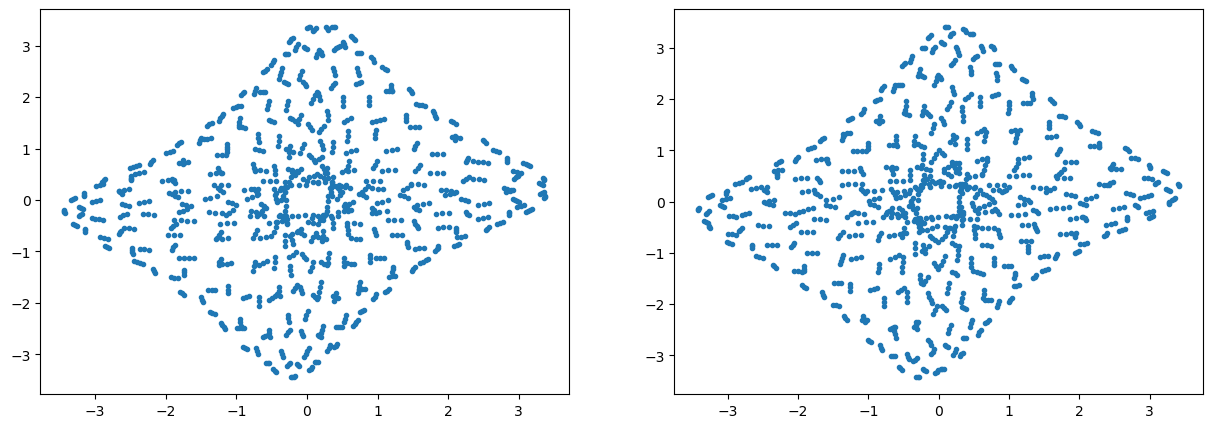

(0.46153846153846156, 0.22419802196164465)

In [2]:
# 2DOF McMillan map
let a=1.6, b=1.0
    K1_invariant(u_in)=begin
        ret=0.0
        for i in 1:4
            ret+=u_in[i]^2
        end
        t=u_in[1]*u_in[2]+u_in[3]*u_in[4]
        ret+=-a*t+b*t^2
    end
    K2_invariant(u_in)=u_in[1]*u_in[4]-u_in[2]*u_in[3]
    McMillan_map(u_in)=begin
        u_out=zeros(Float64,4)
        u_in_norm=1+b*(u_in[2]^2+u_in[4]^2)
        u_out[1]=u_in[2]
        u_out[2]=-u_in[1]+a*u_in[2]/u_in_norm
        u_out[3]=u_in[4]
        u_out[4]=-u_in[3]+a*u_in[4]/u_in_norm
        return u_out
    end
    
    N=1000
    X=zeros(Float64,(4,N+1))
    K1s=zeros(Float64,N+1)
    K2s=zeros(Float64,N+1)
    X[:,1] .= [3.0,0.5,1.0,0.5]
    for i in 1:N
        X[:,i+1] .= McMillan_map(X[:,i])
    end
    for i in 1:length(K1s)
        K1s[i]=K1_invariant(X[:,i])
        K2s[i]=K2_invariant(X[:,i])
    end
    
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    #ax1.plot(K1s);ax2.plot(K2s)
    #ax1.plot(X[1,:]);ax2.plot(X[3,:])
    ax1.plot(X[1,:],X[2,:],".");ax2.plot(X[3,:],X[4,:],".")
    
    # coarse estimate
    let
        r=sqrt.(X[1,:].^2 .+ X[3,:].^2)
        Δθ=atan.((X[1,:] .* X[4,:] .- X[2,:] .* X[3,:]), (X[1,:] .* X[2,:] .+ X[3,:] .* X[4,:])) 
        fs=rfftfreq(N+1)
        As=abs.(rfft(r .- mean(r)))
        νr = fs[argmax(As)]
        νθ = (sum(Δθ) ./ (2pi*(N+1)))
        νr,νθ
    end
end

In [3]:
# time-of-flight parameters for 4D McMillan map
let a=1.6, b=1.0
    K1_invariant(u_in)=begin
        ret=0.0
        for i in 1:4
            ret+=u_in[i]^2
        end
        t=u_in[1]*u_in[2]+u_in[3]*u_in[4]
        ret+=-a*t+b*t^2
    end
    K2_invariant(u_in)=u_in[1]*u_in[4]-u_in[2]*u_in[3]
    function K1_ODE!(du, u, p, t)
        du[1]=2*u[2]-a*u[1]+2b*(u[1]*u[2]+u[3]*u[4])*u[1]
        du[2]=-2*u[1]+a*u[2]-2b*(u[1]*u[2]+u[3]*u[4])*u[2]
        du[3]=2*u[4]-a*u[3]+2b*(u[1]*u[2]+u[3]*u[4])*u[3]
        du[4]=-2*u[3]+a*u[4]-2b*(u[1]*u[2]+u[3]*u[4])*u[4]
        return
    end
    function K2_ODE!(du, u, p, t)
        du[1]=-u[3]
        du[2]=-u[4]
        du[3]=u[1]
        du[4]=u[2]
        return
    end
    McMillan_map(u_in)=begin
        u_out=zeros(Float64,4)
        u_in_norm=1+b*(u_in[2]^2+u_in[4]^2)
        u_out[1]=u_in[2]
        u_out[2]=-u_in[1]+a*u_in[2]/u_in_norm
        u_out[3]=u_in[4]
        u_out[4]=-u_in[3]+a*u_in[4]/u_in_norm
        return u_out
    end
    
    function evolve(u_in, τ1, τ2;dt=1e-3, alg=IRKGL16())
        prob1 = ODEProblem(K1_ODE!, u_in, (0.0, τ1))
        sol1  = solve(prob1, alg; dt=dt, adaptive = false, save_everystep = false, save_start = false)
        u_mid = sol1.u[end]
        prob2 = ODEProblem(K2_ODE!, u_mid, (0.0, τ2))
        sol2  = solve(prob2, alg; dt=dt, adaptive = false, save_everystep = false, save_start = false)
        u_out = sol2.u[end]
        return u_out
    end
    
    function fit(x;u_in,u_out)
        u_fit=evolve(u_in, x[1], x[2])
        #return sum((u_fit .- u_out).^2)
        return u_fit .- u_out
    end


    u0 = [3.0,0.5,1.0,0.5]
    u1 = McMillan_map(u0)
    
    # Determine τ, initial guss = [0.0,0.0] because we don't want integer part of tune
    f(x)=fit(x;u_in=u0, u_out=u1)
    ret0=lso.optimize(f, [0.0,0.0], lso.LevenbergMarquardt(), iterations=1000, f_tol=1e-8, x_tol=1e-8, lower=[0.0,0.0], upper=[100.0,100.0])
    @printf "τ = [%.18f, %.18f], τ_loss = %.16e\n" ret0.minimizer... ret0.ssr
    
    # Determine T matrix, [0.0,0.0] is a trivial solution, the initial guess should stay away from [0.0,0.0]
    # Different guess converges to different solution
    g(x)=fit(x;u_in=u0, u_out=u0)
    ret1=lso.optimize(g, [1.0,0.5], lso.LevenbergMarquardt(), iterations=1000, f_tol=1e-8, x_tol=1e-8, lower=[0.0,0.0], upper=[100.0,100.0])
    @printf "T1 = [%.18f, %.18f], T1_loss = %.16e\n" ret1.minimizer... ret1.ssr
    ret2=lso.optimize(g, [1.0,1.0], lso.LevenbergMarquardt(), iterations=1000, f_tol=1e-8, x_tol=1e-8, lower=[0.0,0.0], upper=[100.0,100.0])
    @printf "T2 = [%.18f, %.18f], T2_loss = %.16e\n" ret2.minimizer... ret2.ssr
end

τ = [0.345071165395968660, 0.210555678165560728], τ_loss = 1.2869455237360209e-26
T1 = [1.496838748842843181, 1.082760731590358239], T1_loss = 3.8530924839388795e-29
T2 = [0.748419374421421812, 3.682973019384971902], T2_loss = 3.5745259767827097e-31


In [4]:
# Calibrate integer matrix and compute frequencies
let 
    τ = [0.345071165395968660, 0.210555678165560728]
    T1 = [1.496838748842843181, 1.082760731590358239]
    T2 = [0.748419374421421812, 3.682973019384971902]
    T=[T1 T2]
    ν_coarse=[0.46153846153846156, 0.22419802196164465]
    
    M=zeros(Int64,(2,2))
    ν=Float64[Inf,Inf]
    for m11 in 0:3, m12 in 0:3, m21 in 0:3, m22 in 0:3
        tM = [m11 m12;m21 m22]
        if det(tM)==0
            continue
        end
        tν=tM*inv(T)*τ
        if norm(tν .- ν_coarse) < norm(ν .- ν_coarse)
            ν .= tν
            M .= tM
        end
    end
    ν |> display
    M |> display
end

2-element Vector{Float64}:
 0.46106658537899536
 0.22431722288200287

2×2 Matrix{Int64}:
 2  1
 1  1